In [3]:
#Set working directories
import os

In [4]:
os.getcwd()

'C:\\Users\\midhu\\Documents\\GitHub\\Restore-tensorflow-model'

In [5]:
#os.chdir("..//")
#os.chdir('.\\Image classifier')

In [6]:
os.getcwd()

'C:\\Users\\midhu\\Documents\\GitHub\\Restore-tensorflow-model'

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import time
from random import shuffle
from tqdm import tqdm as tqdm
#import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from alpha import create_traindata, random_mini_batch


%matplotlib inline

In [8]:
tf.__version__

'1.4.0'

In [9]:
TRAIN_DIR = ".\\train"
IMG_SIZE = 100
img_shape = (IMG_SIZE,IMG_SIZE,3)
num = 200

In [10]:
def create_traindata(num_data = 100, IMG_SIZE = 100, TRAIN_DIR = ".\\train"):
    training_data = []
    training_label = []
    for directory in os.listdir(TRAIN_DIR):
        path1 = os.path.join(TRAIN_DIR, directory)
        for i, img in tqdm(enumerate(os.listdir(path1))):
            if i < num_data:
                label = directory
                path2 = os.path.join(path1, img)
                img = cv2.imread(path2)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                training_label.append([np.array(label)])
                training_data.append([np.array(img)])
    print("{0} Files per each class loaded".format(num_data))
    return np.array(training_data), np.array(training_label)

In [11]:
train, label = create_traindata(num, IMG_SIZE, TRAIN_DIR)

200it [00:02, 82.34it/s]
200it [00:02, 76.14it/s]


200 Files per each class loaded


In [12]:
train = np.array(train).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [13]:
label.shape, train.shape

((400, 1), (400, 100, 100, 3))

In [14]:
#Shuffle
def shuffle_data(X, Y):
    m = X.shape[0]
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    return shuffled_X, shuffled_Y

In [15]:
train, label = shuffle_data(train, label)

In [16]:
label_df = pd.DataFrame(label, columns = ['classes'])

In [17]:
label_df.head()

,classes
0,dog
1,cat
2,dog
3,cat
4,cat


In [18]:
en = LabelEncoder()
en.fit(label_df.classes)
encoded_label = en.transform(label_df.classes)

In [19]:
label_df["encoded_label"] = encoded_label

In [20]:
label_df.head()

,classes,encoded_label
0,dog,1
1,cat,0
2,dog,1
3,cat,0
4,cat,0


In [21]:
type(encoded_label)

numpy.ndarray

In [22]:
one_hot_label = (np.arange(2) == encoded_label[:,None]).astype(np.float32)

In [23]:
#one_hot_label = np.asmatrix(one_hot_label)
#one_hot_label

Target variable is all set to go
#set up the training data now

In [24]:
train.shape

(400, 100, 100, 3)

Function for ploting the images

In [25]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 25
    
    #create fig with 5x5 sub-plots
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred = {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

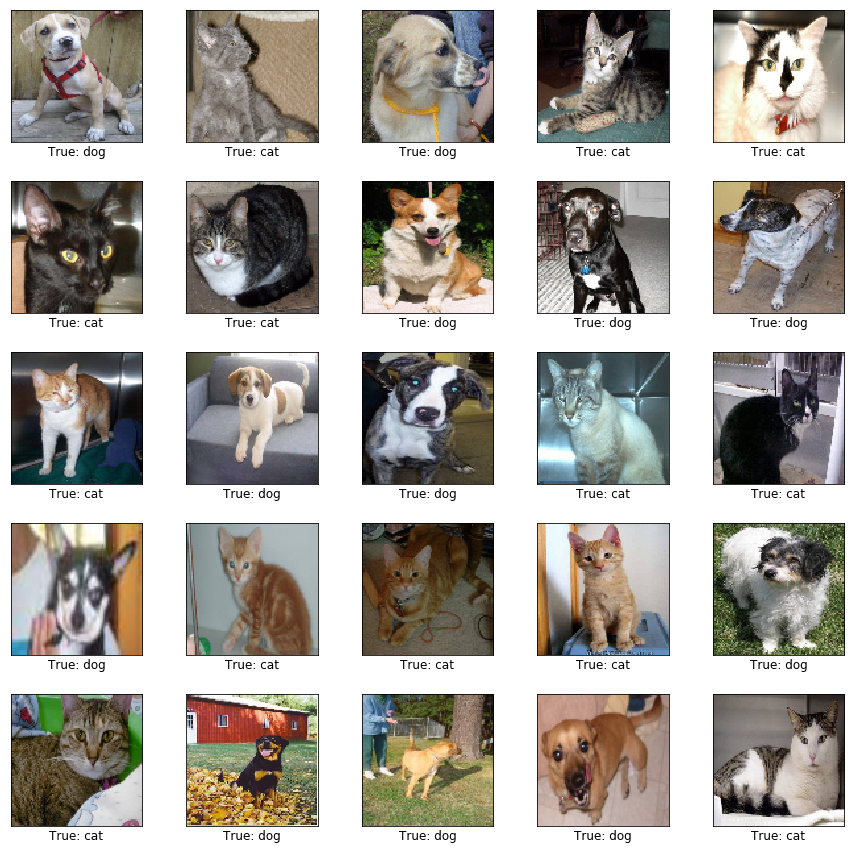

In [26]:
#get 25 images to plot
images = train[:25]
cls_true = label_df.classes[:25]
cls_pred = None
plot_images(images, cls_true)

Split the data

In [27]:
x_train = train[:-50,:,:,:]
x_val = train[-50:,:,:,:]

In [28]:
y_train = one_hot_label[:-50,:]
y_val = one_hot_label[-50:,:]
label_val = np.array(label_df["classes"].iloc[-50:])
encoded_label_val = encoded_label[-50:] #for confusion matrix in the end

In [29]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((350, 100, 100, 3), (350, 2), (50, 100, 100, 3), (50, 2))

In [30]:
label_val[:5]

array(['cat', 'cat', 'dog', 'cat', 'cat'], dtype=object)

In [31]:
def compute_cost(Z, Y):
    with tf.name_scope("cost"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
        tf.summary.scalar("cost", cost)
    return cost

In [32]:
#Placeholder
def create_placeholders(n_H0, n_W0, n_C0, n_y): 
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [33]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        #act = tf.nn.dropout(act, keep_prob =0.7)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [34]:
def fc_layer(input, size_in, size_out, name="fc"):
      with tf.name_scope(name):
            w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
            Z = tf.matmul(input, w) + b
            tf.summary.histogram("weights", w)
            tf.summary.histogram("biases", b)
            tf.summary.histogram("activations", act)
            return Z

In [35]:
#Model
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.005, num_epochs = 2, minibatch_size = 64):
    tf.reset_default_graph() 
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    #global pred
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    conv1 = conv_layer(X,     3,  8,  "conv1")
    conv2 = conv_layer(conv1, 8,  16, "conv2")
    conv3 = conv_layer(conv2, 16, 32, "conv3")
    conv4 = conv_layer(conv3, 32, 64, "conv4")
    

    flattened = tf.contrib.layers.flatten(conv4)
    
    fc1 = tf.contrib.layers.fully_connected(flattened, 128, activation_fn = None)
    Z   = tf.contrib.layers.fully_connected(fc1,       2,   activation_fn = None)
    
    cost = compute_cost(Z, Y)    

    global_step = tf.Variable(0, name="global_sstep", trainable=False) #Iteration
    
    with tf.name_scope("optimize"):
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)#Backprop
    
    
    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(Z, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)
    
    summaryMerged = tf.summary.merge_all() #Merge all summary #For graph
    
    
    saver = tf.train.Saver() #Saver object
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.\\saved_models'))
        
        
        
        filename="./summary_log/run"+time.strftime("%m%d-%H%M") #For graph
        writer = tf.summary.FileWriter(filename, sess.graph) #For graph
        for epoch in range(num_epochs):
            avg_cost = 0
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            minibatches = random_mini_batch(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
            
                (minibatch_X, minibatch_Y) = minibatch
                #fit
                sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
                #avg loss
                avg_cost += sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})/num_minibatches
                #Write logs
                
                iteration = sess.run(global_step)
                if iteration>15 :
                    summ = sess.run(summaryMerged, feed_dict={X: minibatch_X, Y: minibatch_Y})
                    writer.add_summary(summ, (iteration))
               
                #plot logs
                if iteration % 10 ==0:
                    #print("Iteration: %4 ; cost = %" %(epoch + 1, avg_cost))
                    print ("Cost after iteration %i: %f " % (iteration, avg_cost))
        saver.save(sess, "./saved_models/"+time.strftime("%d-%m--%H%M"))# Save model
        #saver.save(sess, "./saved_model/run"+time.strftime("%Y%m%d-%H%M%S")+"/model.ckpt", global_step=epoch,write_meta_graph=False)
        print("Training completed!!")
        

        #model accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))*100
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_val, Y: Y_val})
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        #one step forwardprop
        predict_op = tf.argmax(Z, 1) 
        pred = sess.run(predict_op, feed_dict={X: X_val})
        
    
    return pred

In [42]:
pred_model= model(x_train, y_train, x_val, y_val, num_epochs = 5, minibatch_size = 32, learning_rate = 0.001)

INFO:tensorflow:Restoring parameters from .\saved_models\17-02--1927
Cost after iteration 170: 0.286229 
Cost after iteration 180: 0.225738 
Cost after iteration 190: 0.165484 
Cost after iteration 200: 0.113101 
Cost after iteration 210: 0.049039 
Cost after iteration 220: 0.603846 
Training completed!!
Tensor("mul:0", shape=(), dtype=float32)
Train Accuracy: 74.0
Test Accuracy: 68.0


In [43]:
pred_model

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0], dtype=int64)

In [44]:
#Model
def predict(X_val, Y_val):
    
    tf.reset_default_graph() 
    (m, n_H0, n_W0, n_C0) = X_val.shape             
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    
    
    
    conv1 = conv_layer(X,     3,  8,  "conv1")
    conv2 = conv_layer(conv1, 8,  16, "conv2")
    conv3 = conv_layer(conv2, 16, 32, "conv3")
    conv4 = conv_layer(conv3, 32, 64, "conv4")
    

    flattened = tf.contrib.layers.flatten(conv4)
    
    fc1 = tf.contrib.layers.fully_connected(flattened, 128, activation_fn = None)
    Z   = tf.contrib.layers.fully_connected(fc1,       2,   activation_fn = None)
  
    #summaryMerged = tf.summary.merge_all()
    
    #Saver object
    saver = tf.train.Saver()
    with tf.Session() as sess:
        k = saver.restore(sess, tf.train.latest_checkpoint('./saved_models'))
        #filename="./summary_log_1/run"+time.strftime("%Y%m%d-%H%M%S")
        #writer = tf.summary.FileWriter(filename, sess.graph) 
        
        #one step forwardprop
        #prob = sess.run((tf.nn.softmax(Z)), feed_dict={X:X_val})
        predict_op = tf.argmax(Z, 1) 
        pred = sess.run(predict_op, feed_dict={X: X_val})
        
    return pred #prob

In [45]:
pred_predict= predict(x_val, y_val)

INFO:tensorflow:Restoring parameters from ./saved_models\17-02--1928


In [46]:
pred_predict

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0], dtype=int64)